In [1]:

# Import libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image, ImageDraw

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading Dataset from torchvision

100%|██████████| 2.00G/2.00G [01:57<00:00, 17.1MB/s]


Training dataset size: 5717
Validation dataset size: 5823
Sample annotation structure:
{
  "annotation": {
    "folder": "VOC2012",
    "filename": "2008_000008.jpg",
    "source": {
      "database": "The VOC2008 Database",
      "annotation": "PASCAL VOC2008",
      "image": "flickr"
    },
    "size": {
      "width": "500",
      "height": "442",
      "depth": "3"
    },
    "segmented": "0",
    "object": [
      {
        "name": "horse",
        "pose": "Left",
        "truncated": "0",
        "occluded": "1",
        "bndbox": {
          "xmin": "53",
          "ymin": ...


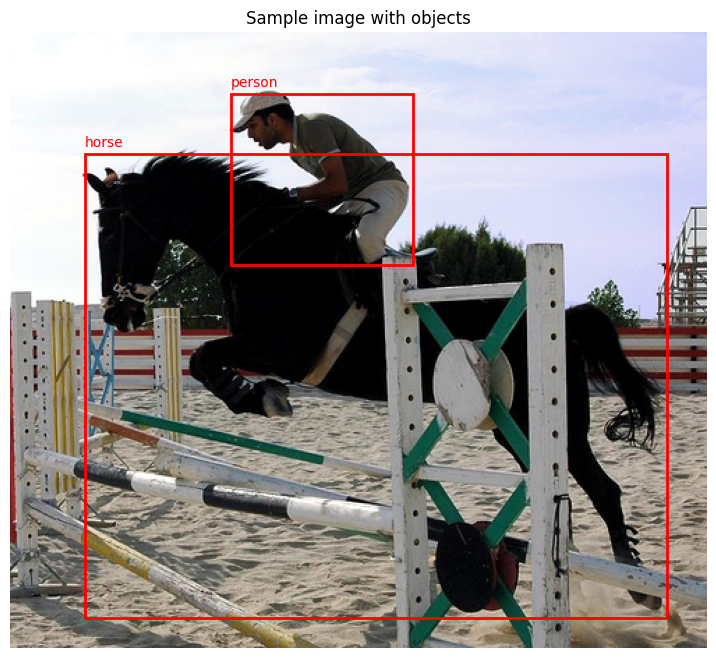

In [2]:
# Load the PASCAL VOC dataset from torchvision which has bounding box annotations
from torchvision.datasets import VOCDetection
import os

# This will download the dataset to the specified directory if not already present
voc_root = './data'
os.makedirs(voc_root, exist_ok=True)

# Download training dataset (might take a while the first time)
train_dataset_raw = VOCDetection(root=voc_root, year='2012', image_set='train', download=True)
val_dataset_raw = VOCDetection(root=voc_root, year='2012', image_set='val', download=True)

print(f"Training dataset size: {len(train_dataset_raw)}")
print(f"Validation dataset size: {len(val_dataset_raw)}")

# Let's look at a sample from the dataset
sample_idx = 0
image, annotation = train_dataset_raw[sample_idx]

# Print annotation structure
print("Sample annotation structure:")
import json
print(json.dumps(annotation, indent=2)[:500] + "...")  # Show first 500 chars

# Display sample image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title(f"Sample image with objects")

# Draw bounding boxes
from matplotlib.patches import Rectangle
ax = plt.gca()

# Extract objects and their bounding boxes
objects = annotation['annotation']['object']
if not isinstance(objects, list):
    objects = [objects]  # Handle case with single object

for obj in objects:
    # VOC format: [xmin, ymin, xmax, ymax]
    bbox = obj['bndbox']
    xmin = int(bbox['xmin'])
    ymin = int(bbox['ymin'])
    xmax = int(bbox['xmax'])
    ymax = int(bbox['ymax'])
    width = xmax - xmin
    height = ymax - ymin

    category = obj['name']
    rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(xmin, ymin-5, category, color='red')

plt.axis('off')
plt.show()

## Preprocessing and Data Preparation


In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Import DataLoader
from torch.utils.data import DataLoader # This line is added to import DataLoader

# Create a class for our custom dataset with bounding boxes
class VOCLocalizationDataset(torch.utils.data.Dataset):
    def __init__(self, voc_dataset, transform=None, single_object=True):
        self.voc_dataset = voc_dataset
        self.transform = transform
        self.single_object = single_object

        # Get list of all unique categories
        self.class_names = []
        for idx in range(len(voc_dataset)):
            image, annotation = voc_dataset[idx]
            objects = annotation['annotation']['object']
            if not isinstance(objects, list):
                objects = [objects]  # Handle case with single object

            for obj in objects:
                self.class_names.append(obj['name'])

        self.class_names = sorted(list(set(self.class_names)))
        self.num_classes = len(self.class_names)

        # Create a mapping from class name to index
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        image, annotation = self.voc_dataset[idx]

        # Get all objects in the image
        objects = annotation['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]  # Handle case with single object

        if self.single_object:
            # For simplicity, we'll just use the first object in the image
            # In a real scenario, you might handle multiple objects differently
            obj = objects[0]
            category = obj['name']
            bbox = obj['bndbox']

            # Convert category to label index
            label = self.class_to_idx[category]

            # Convert VOC format [xmin, ymin, xmax, ymax] to [x, y, width, height]
            width, height = image.size
            xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])

            # Normalize bounding box coordinates (0 to 1)
            x_norm = xmin / width
            y_norm = ymin / height
            w_norm = (xmax - xmin) / width
            h_norm = (ymax - ymin) / height

            # Apply transformations to the image
            if self.transform:
                image = self.transform(image)

            # Return image, class label and bounding box
            return image, label, torch.tensor([x_norm, y_norm, w_norm, h_norm], dtype=torch.float)
        else:
            # Handle multi-object case (more complex)
            # This would be implemented for multi-object detection tasks
            pass

# Create train and validation datasets
train_dataset = VOCLocalizationDataset(train_dataset_raw, transform)
test_dataset = VOCLocalizationDataset(val_dataset_raw, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training data size: {len(train_dataset)}")
print(f"Test data size: {len(test_dataset)}")

Training data size: 5717
Test data size: 5823


## Building the Classification + Localization Model Coding

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ClassificationLocalizationModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationLocalizationModel, self).__init__()
        # Use a pre-trained model as the backbone
        self.backbone = models.resnet18(pretrained=True)

        # Replace final fully connected layer for our task
        in_features = self.backbone.fc.in_features # accesses the number of input features to that fully connected layer

        # Remove the final layer
        self.backbone.fc = nn.Identity()

        # Create separate heads for classification and localization
        self.classification_head = nn.Linear(in_features, num_classes)
        self.localization_head = nn.Linear(in_features, 4)  # (x, y, w, h)

    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone(x)

        # Predict class
        class_logits = self.classification_head(features)

        # Predict bounding box (x, y, w, h)
        # Using sigmoid ensures the values are between 0 and 1
        bbox = torch.sigmoid(self.localization_head(features))

        return class_logits, bbox

# Create the model
num_classes = train_dataset.num_classes
model = ClassificationLocalizationModel(num_classes).to(device)
print(model)

# Define loss functions and optimizer
classification_criterion = nn.CrossEntropyLoss()
localization_criterion = nn.SmoothL1Loss()  # Also known as Huber loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


ClassificationLocalizationModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

## Training the Model

In [5]:
def train_one_epoch(model, train_loader, optimizer, classification_criterion, localization_criterion, device):
    model.train()
    running_loss = 0.0
    class_loss_total = 0.0
    loc_loss_total = 0.0
    correct = 0
    total = 0

    for i, (images, labels, boxes) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        boxes = boxes.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        class_logits, predicted_boxes = model(images)

        # Calculate losses
        classification_loss = classification_criterion(class_logits, labels)
        localization_loss = localization_criterion(predicted_boxes, boxes)

        # Combined loss (can adjust weights if needed)
        loss = classification_loss + localization_loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        class_loss_total += classification_loss.item()
        loc_loss_total += localization_loss.item()

        # Calculate accuracy
        _, predicted = class_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Batch {i+1}, Loss: {running_loss/(i+1):.4f}, Class Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    class_loss_avg = class_loss_total / len(train_loader)
    loc_loss_avg = loc_loss_total / len(train_loader)
    accuracy = 100. * correct / total

    return epoch_loss, class_loss_avg, loc_loss_avg, accuracy

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    epoch_loss, class_loss, loc_loss, accuracy = train_one_epoch(
        model, train_loader, optimizer, classification_criterion, localization_criterion, device
    )
    print(f'Loss: {epoch_loss:.4f}, Class Loss: {class_loss:.4f}, Loc Loss: {loc_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/10
Batch 100, Loss: 1.9410, Class Acc: 41.00%
Loss: 1.8501, Class Loss: 1.8226, Loc Loss: 0.0275, Accuracy: 43.45%
Epoch 2/10
Batch 100, Loss: 1.3779, Class Acc: 57.28%
Loss: 1.4391, Class Loss: 1.4146, Loc Loss: 0.0245, Accuracy: 55.94%
Epoch 3/10
Batch 100, Loss: 1.0882, Class Acc: 66.53%
Loss: 1.1586, Class Loss: 1.1352, Loc Loss: 0.0233, Accuracy: 64.11%
Epoch 4/10
Batch 100, Loss: 0.8560, Class Acc: 73.31%
Loss: 0.8875, Class Loss: 0.8655, Loc Loss: 0.0219, Accuracy: 72.38%
Epoch 5/10
Batch 100, Loss: 0.5889, Class Acc: 82.06%
Loss: 0.6569, Class Loss: 0.6353, Loc Loss: 0.0217, Accuracy: 79.97%
Epoch 6/10
Batch 100, Loss: 0.3854, Class Acc: 88.88%
Loss: 0.4177, Class Loss: 0.3965, Loc Loss: 0.0212, Accuracy: 87.67%
Epoch 7/10
Batch 100, Loss: 0.2818, Class Acc: 91.47%
Loss: 0.3475, Class Loss: 0.3269, Loc Loss: 0.0207, Accuracy: 89.47%
Epoch 8/10
Batch 100, Loss: 0.2539, Class Acc: 92.72%
Loss: 0.2644, Class Loss: 0.2439, Loc Loss: 0.0205, Accuracy: 92.23%
Epoch 9/10
Batch

## Evaluating the Model

In [6]:
def evaluate(model, test_loader, classification_criterion, localization_criterion, device):
    model.eval()
    test_loss = 0.0
    class_loss_total = 0.0
    loc_loss_total = 0.0
    correct = 0
    total = 0

    # For calculating IoU (Intersection over Union)
    total_iou = 0.0

    with torch.no_grad():
        for images, labels, boxes in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            boxes = boxes.to(device)

            # Forward pass
            class_logits, predicted_boxes = model(images)

            # Calculate losses
            classification_loss = classification_criterion(class_logits, labels)
            localization_loss = localization_criterion(predicted_boxes, boxes)

            # Combined loss
            loss = classification_loss + localization_loss

            # Statistics
            test_loss += loss.item()
            class_loss_total += classification_loss.item()
            loc_loss_total += localization_loss.item()

            # Calculate accuracy
            _, predicted = class_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Calculate IoU for bounding boxes
            batch_iou = calculate_iou(predicted_boxes.cpu().numpy(), boxes.cpu().numpy())
            total_iou += batch_iou.sum()

    test_loss /= len(test_loader)
    class_loss_avg = class_loss_total / len(test_loader)
    loc_loss_avg = loc_loss_total / len(test_loader)
    accuracy = 100. * correct / total
    mean_iou = total_iou / total

    print(f'Test Loss: {test_loss:.4f}, Class Loss: {class_loss_avg:.4f}, Loc Loss: {loc_loss_avg:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%, Mean IoU: {mean_iou:.4f}')

    return test_loss, accuracy, mean_iou

def calculate_iou(predicted_boxes, ground_truth_boxes):
    """
    Calculate IoU between predicted and ground truth bounding boxes
    Boxes format: [x, y, width, height] (normalized)
    """
    # Convert from [x, y, width, height] to [x1, y1, x2, y2]
    def to_xyxy(boxes):
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 0] + boxes[:, 2]
        y2 = boxes[:, 1] + boxes[:, 3]
        return np.stack([x1, y1, x2, y2], axis=1)

    pred_boxes = to_xyxy(predicted_boxes)
    gt_boxes = to_xyxy(ground_truth_boxes)

    # Calculate intersection
    intersect_x1 = np.maximum(pred_boxes[:, 0], gt_boxes[:, 0])
    intersect_y1 = np.maximum(pred_boxes[:, 1], gt_boxes[:, 1])
    intersect_x2 = np.minimum(pred_boxes[:, 2], gt_boxes[:, 2])
    intersect_y2 = np.minimum(pred_boxes[:, 3], gt_boxes[:, 3])

    intersect_width = np.maximum(0, intersect_x2 - intersect_x1)
    intersect_height = np.maximum(0, intersect_y2 - intersect_y1)

    intersection_area = intersect_width * intersect_height

    # Calculate areas
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])

    # Calculate union
    union_area = pred_area + gt_area - intersection_area

    # Calculate IoU
    iou = intersection_area / (union_area + 1e-6)  # Add small epsilon to avoid division by zero

    return iou

# Evaluate the model
test_loss, test_accuracy, mean_iou = evaluate(model, test_loader, classification_criterion, localization_criterion, device)


Test Loss: 2.5023, Class Loss: 2.4795, Loc Loss: 0.0228
Test Accuracy: 51.50%, Mean IoU: 0.3990


## Visualizing Results

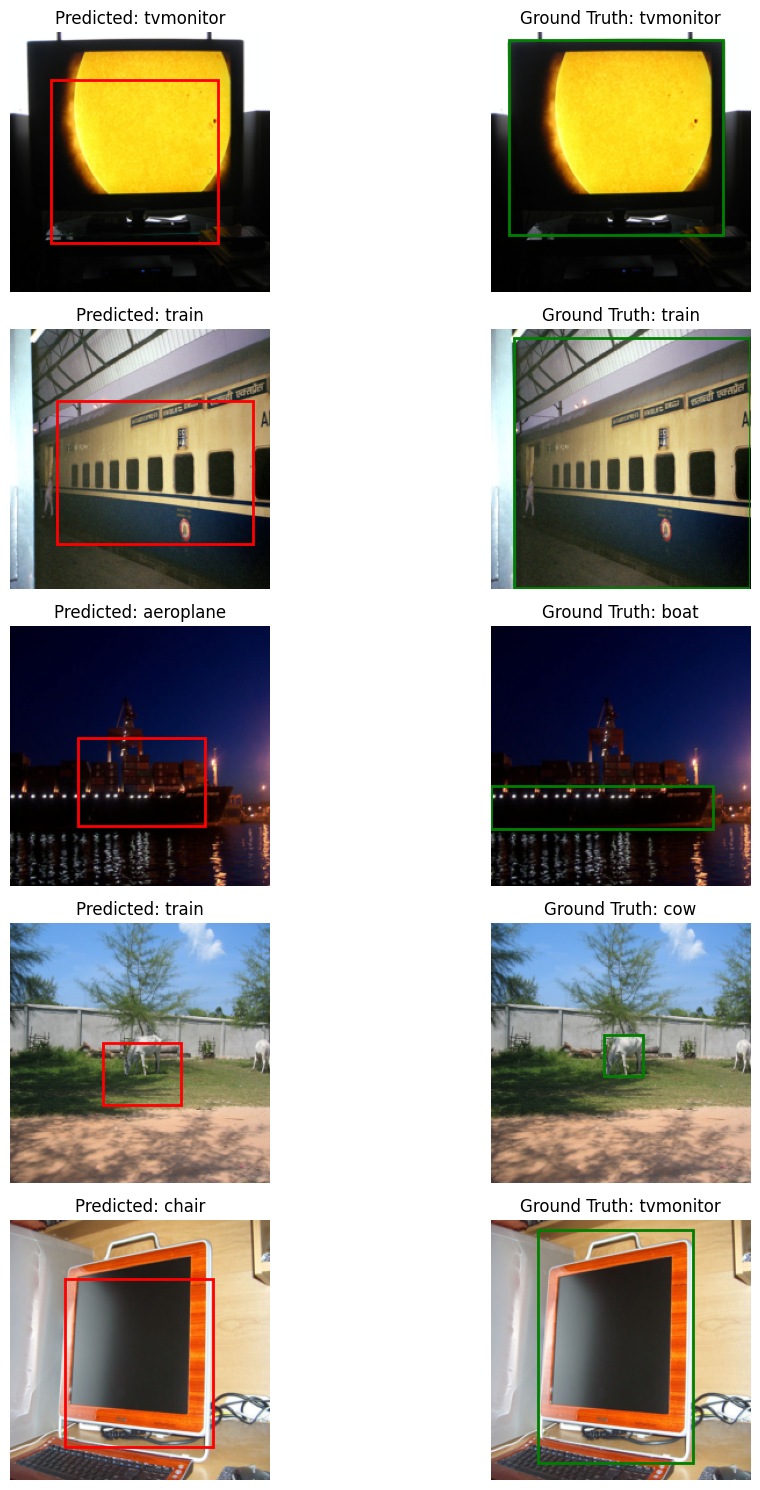

In [7]:
def visualize_predictions(model, test_loader, class_names, device, num_samples=5):
    model.eval()

    # Get some test images
    dataiter = iter(test_loader)
    images, labels, gt_boxes = next(dataiter)

    # Make predictions
    with torch.no_grad():
        images_device = images[:num_samples].to(device)
        class_logits, predicted_boxes = model(images_device)

        # Get predicted classes
        _, predicted_classes = class_logits.max(1)

    # Convert to numpy for visualization
    images = images[:num_samples].cpu().numpy()
    predicted_classes = predicted_classes.cpu().numpy()
    predicted_boxes = predicted_boxes[:num_samples].cpu().numpy()
    gt_boxes = gt_boxes[:num_samples].cpu().numpy()
    labels = labels[:num_samples].cpu().numpy()

    # Transpose images from [batch, channel, height, width] to [batch, height, width, channel]
    images = np.transpose(images, (0, 2, 3, 1))

    # Denormalize images
    images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    images = np.clip(images, 0, 1)

    # Plot images with predicted and ground truth boxes
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, 3*num_samples))

    for i in range(num_samples):
        image = images[i]
        pred_class = predicted_classes[i]
        gt_class = labels[i]

        # Get normalized box coordinates
        pred_box = predicted_boxes[i]  # [x, y, width, height]
        gt_box = gt_boxes[i]  # [x, y, width, height]

        # Convert normalized box to pixel coordinates
        height, width = image.shape[0], image.shape[1]
        pred_box_pixels = [
            int(pred_box[0] * width),  # x
            int(pred_box[1] * height),  # y
            int(pred_box[2] * width),   # width
            int(pred_box[3] * height)   # height
        ]

        gt_box_pixels = [
            int(gt_box[0] * width),     # x
            int(gt_box[1] * height),    # y
            int(gt_box[2] * width),     # width
            int(gt_box[3] * height)     # height
        ]

        # Plot predicted box
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Predicted: {class_names[pred_class]}')
        axs[i, 0].add_patch(plt.Rectangle(
            (pred_box_pixels[0], pred_box_pixels[1]),
            pred_box_pixels[2], pred_box_pixels[3],
            fill=False, edgecolor='red', linewidth=2
        ))
        axs[i, 0].axis('off')

        # Plot ground truth box
        axs[i, 1].imshow(image)
        axs[i, 1].set_title(f'Ground Truth: {class_names[gt_class]}')
        axs[i, 1].add_patch(plt.Rectangle(
            (gt_box_pixels[0], gt_box_pixels[1]),
            gt_box_pixels[2], gt_box_pixels[3],
            fill=False, edgecolor='green', linewidth=2
        ))
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some test results
visualize_predictions(model, test_loader, train_dataset.class_names, device)

## Save and Load the Model


In [8]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': train_dataset.class_names,  # Save class names for inference
}, 'voc_classification_localization_model.pth')

# Load the model
def load_model(model_path, num_classes, device):
    model = ClassificationLocalizationModel(num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Example of loading the model
# loaded_model = load_model('voc_classification_localization_model.pth', num_classes, device)